# =====================================
#  4A - L1 Introduction to "features"
# =====================================

## Image Point Matching Problem

- Suppose I have two images related by some transformation Or have two images of the same object in different positions.
- How to find the transformation of image 1 that would align it with image 2


<br />
<figure>
  <img src="imgs/transformation.png" />
  <center><figcaption>Fig.1(a): Transformation</figcaption></center>
</figure>

### We want Local$ ^{(1)}$ Features$ ^{(2)}$

*Not machine learning features, but things that we compute about little region or spots*

- Goal: Find point in an image that can be:
    - Found in other images
    - Found precisely - well localized
    - Found reliably - well matched
    
Why?

- Want to compute a fundamental matrix to recover geometry
- Robotics/vision: See how a bunch of points move from one frame to another. Allows computation of how camera moved -> depth -> moving objects
- Build a panorama


<br />
<figure>
  <img src="imgs/building_panorama.gif" />
  <center><figcaption>Fig.1(b): Building panorama</figcaption></center>
</figure>



## Matching with Features

- Detect features (features points) in both images
- Match features - find corresponding pairs
- Use these pairs to align images

<br />
<figure>
  <img src="imgs/detecting_points.png" />
  <center><figcaption>Fig.2(a): Similar Points</figcaption></center>
</figure>
<figure>
  <img src="imgs/detecting_points2.png" />
  <center><figcaption>Fig.2(b): Result</figcaption></center>
</figure>

- Problem 1:
    - Detec the same point independently in both
<br />
<br />
<figure>
  <img src="imgs/detecting_points3.png" />
  <center><figcaption>Fig.2 (c): No chance to match</figcaption></center>
</figure>

<center><font color="green">We need a repeatable detector</font></center>


- Problem 2:
    - For each point correctly recognize the corresponding one
<br />
<br />
<figure>
  <img src="imgs/detecting_points3.png" />
  <center><figcaption>Fig.2 (d): Which point is which</figcaption></center>
</figure>

<center><font color="green">We need a reliable and distinctive descriptor</font></center>


### More motivation...

- Feature points are used also for:
    - Image alignment (e.g. homography or fundamental matrix)
    - 3D reconstruction
    - Mortion tracking
    - Object recognition
    - Indexing and database retrieval
    - Robot navigation
    - ... Other

<font color="blue">**Quize**</font>

<figure>
  <img src="imgs/good_feature_quiz.png" />
  <center><figcaption>Good feature quize</figcaption></center>
</figure>

## Characteristics of Good Features

### Repeatability/Precision
- The same feature can be found in several images despite geometric and photometric transformation

### Saliency/Matchability
- Each feature has a distinctive description

### Compactness and efficiency
- Many fewer features than image pixels

### Locality
- A feature occupies a relatively small area of the image; robust to clutter and occlusion


In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import PIL
from io import BytesIO
from IPython.display import clear_output, Image as NoteImage, display
def imshow(im,fmt='jpeg'):
    #a = np.uint8(np.clip(im, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(im).save(f, fmt)
    display(NoteImage(data=f.getvalue()))
def imread(filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
def red(im):
    return im[:,:,0]
def green(im):
    return im[:,:,1]
def blue(im):
    return im[:,:,2]
def gray(im):
    return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
def square(img,center,size,color=(0,255,0)):
    y,x = center
    leftUpCorner = (x-size,y-size)
    rightDownCorner = (x+size,y+size)
    cv2.rectangle(img,leftUpCorner,rightDownCorner,color,3)
def normalize_img(s):
    start = 0
    end = 255
    width = end - start
    res = (s - s.min())/(s.max() - s.min()) * width + start
    return res.astype(np.uint8)
def line(img,x):
    cv2.line(img,(0,x),(img.shape[1],x),(255,0,0),3) 
def mse(imageA, imageB):
        # the 'Mean Squared Error' between the two images is the
        # sum of the squared difference between the two images;
        # NOTE: the two images must have the same dimension
        err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
        err /= float(imageA.shape[0] * imageA.shape[1])
        # return the MSE, the lower the error, the more "similar"
        # the two images are
        return err
def random_color():
    color = list(np.random.choice(range(256), size=3))
    return (int(color[0]),int(color[1]),int(color[2]))

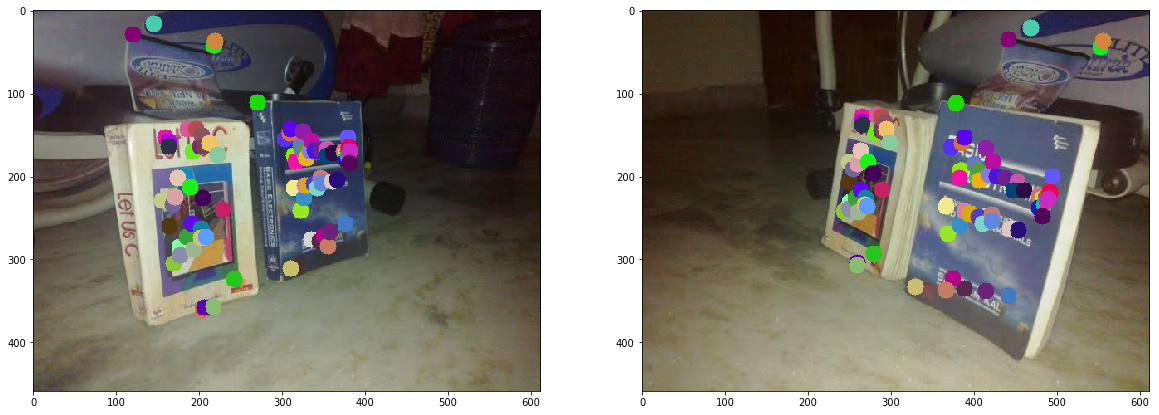

In [34]:
import numpy as np


img1 = imread('imgs/left.jpg') #queryimage # left image
img2 = imread('imgs/right.jpg') #trainimage # right image

gimg1=red(img1)
gimg2=red(img2)

sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(gimg1,None)
kp2, des2 = sift.detectAndCompute(gimg2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

for p1,p2 in zip(pts1,pts2):
    c = random_color()
    cv2.circle(img1,(int(p1[0]),int(p1[1])),10,c,-11)
    cv2.circle(img2,(int(p2[0]),int(p2[1])),10,c,-11)

# img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)
fig = plt.gcf()
fig.set_size_inches((20,15))
plt.subplot(121),plt.imshow(img1)
plt.subplot(122),plt.imshow(img2)
plt.show()



# =====================================
#  4A - L2 Finding corners
# =====================================

## Corner Detection

<br />
<figure>
  <img src="imgs/corner_detection.png" />
  <center><figcaption>Fig.3: Corner detection basic idea</figcaption></center>
</figure>

## Haris Corners

### Mathematics

Change in appearance for the shift [u,v]:

$$E(u,v)=\sum_{x,y}w(x,y)[I(x + u,y+v)-I(x,y)]^2$$

$I$: Intensity image
$u,v$: are small shifts
$w$: window function

**Window function w(x,y) can be 1 in window, 0 outside or Gaussian**


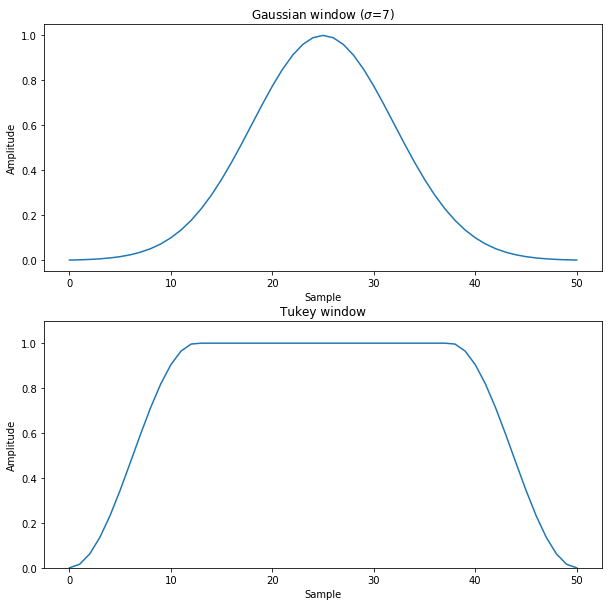

In [47]:
from scipy import signal
from scipy.fftpack import fft, fftshift
import matplotlib.pyplot as plt

window = signal.gaussian(51, std=7)
ax1 = plt.subplot(211)
ax1.plot(window)
ax1.set_title(r"Gaussian window ($\sigma$=7)")
ax1.set_ylabel("Amplitude")
ax1.set_xlabel("Sample")

window = signal.tukey(51)
ax2 = plt.subplot(212)
ax2.plot(window)
ax2.set_title("Tukey window")
ax2.set_ylabel("Amplitude")
ax2.set_xlabel("Sample")
ax2.set_ylim([0, 1.1])

fig = plt.gcf()
fig.set_size_inches((10,10))

## Harris Corners Illustrated

Explanation in the lecture video

<br />
<figure>
  <img src="imgs/harris_corner.png" />
  <center><figcaption>Fig.4: Energy Equation </figcaption></center>
</figure>

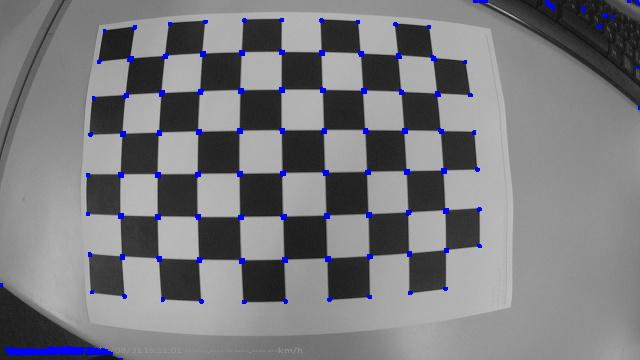

In [2]:
filename = 'imgs/chess.jpg'
img = imread(filename)
gimg = gray(img)
gimg = np.float32(gimg)
dst = cv2.cornerHarris(gimg,2,3,0.04)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

imshow(img)

# 🤴 <font color='red'>Lets try it on the King Messi</font> 🤴

In [4]:
def calculate_haris_corner(filename):
    filename = filename
    img = imread(filename)
    gimg = gray(img)
    gimg = np.float32(gimg)
    dst = cv2.cornerHarris(gimg,2,3,0.04)

    #result is dilated for marking the corners, not important
    dst = cv2.dilate(dst,None)

    # Threshold for an optimal value, it may vary depending on the image.
    img[dst>0.01*dst.max()]=[0,0,255]

    imshow(img)

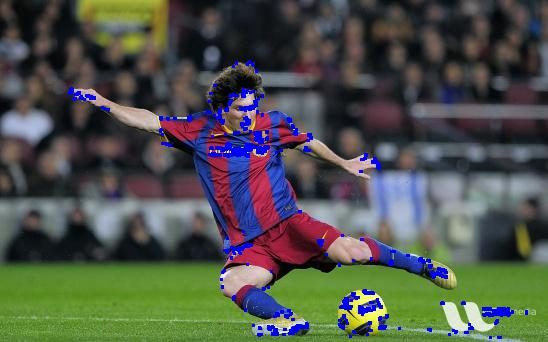

In [5]:
calculate_haris_corner("imgs/messi.jpg")

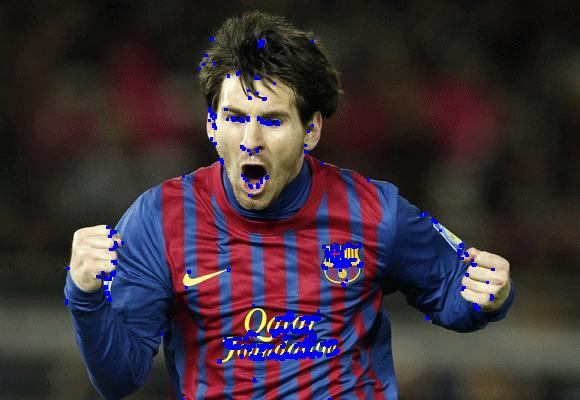

In [6]:
calculate_haris_corner("imgs/messi4.jpg")

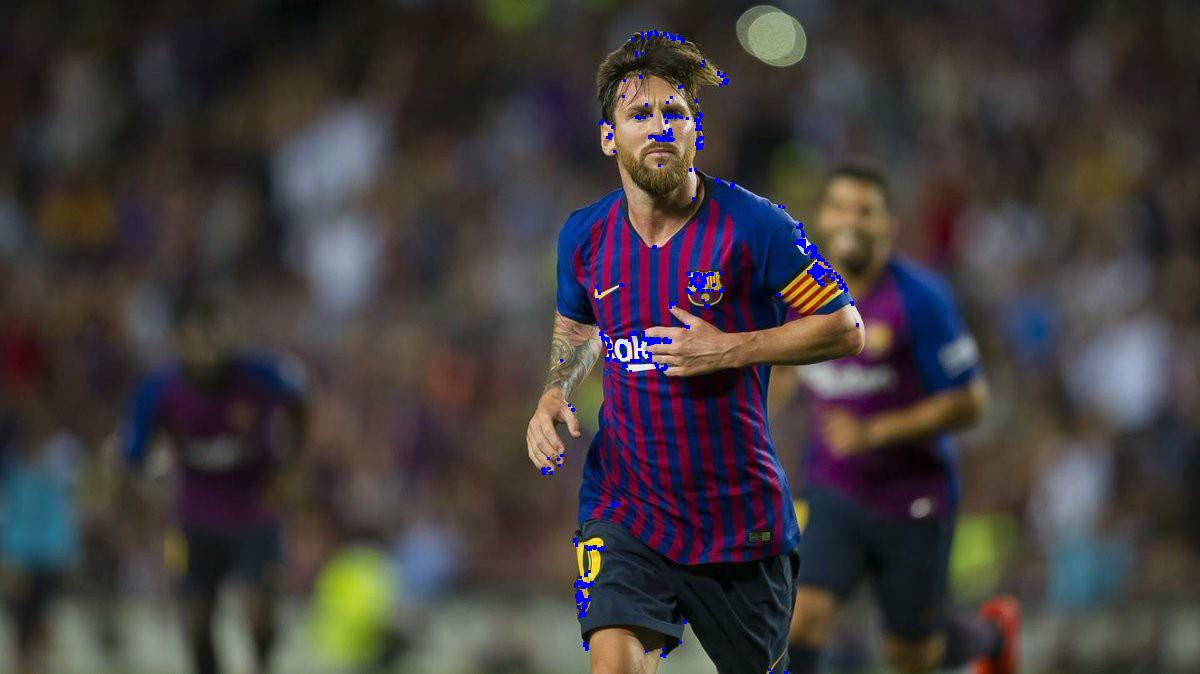

In [7]:
calculate_haris_corner("imgs/messi_alaves.jpg")

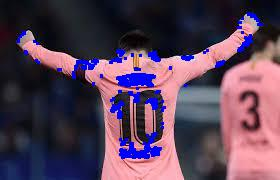

In [8]:
calculate_haris_corner("imgs/messi_espanyol.jpg")

# 👑<font color='red'>2 days ago, Lionel Messi scored two direct free-kicks in a single La Liga game for the first time as Barcelona beat Espanyol to move three points clear at the top.</font>👑





## Small Shifts

$$E(u,v)=\sum_{x,y}w(x,y)[I(x + u,y+v)-I(x,y)]^2$$

We want to find out how the error/energy function behaves for small shifts (u,v near 0,0)

We are going to do second-order Taylor expansion of E(u,v) about (0,0) (local quadratic approximation for small (u,v)

$$F(\delta x) \approx F(0) + \delta x \cdot \frac{dF(0)}{dx} + \frac{1}{2}\delta x^2\cdot\frac{d^2F(0)}{dx^2}$$


$$E(u,v) \approx E(0,0) + \begin{bmatrix}u&v\end{bmatrix} \begin{bmatrix}E_u(0,0)\\E_v(0,0)\end{bmatrix}  + \frac{1}{2}\begin{bmatrix}u&v\end{bmatrix}\begin{bmatrix}E_{uu}(0,0) & E_{uv}(0,0)\\E_{uv}(0,0)&E_{vv}(0,0)\end{bmatrix} \begin{bmatrix}u \\ v\end{bmatrix} $$

## Second- Order Taylor Expansion

Second-order Taylor expansion of E(u,v) about (0,0)
<br />

$$E_u(u,v) = \sum_{x,y}2w(x,y)[I(x+u,y+v)-I(x,y)]I_x(x+u,y+v)$$

u: is the offset in the x direction

$$E_{uu}(u,v) = \sum_{x,y}2w(x,y)I_x(x+u,y+v)I_x(x+u,y+v) + \sum_{x,y}2w(x,y)[I(x+u,y+v)-I(x,y)]I_{xx}(x+u,y+v)$$


<br/>

$$E_{uv}(u,v) = \sum_{x,y}2w(x,y)I_y(x+u,y+v)I_x(x+u,y+v) + \sum_{x,y}2w(x,y)[I(x+u,y+v)-I(x,y)]I_{xy}(x+u,y+v)$$


**Evalute E and its deivatives at (0,0)**


$$E(u,v) \approx E(0,0) + \begin{bmatrix}u&v\end{bmatrix} \begin{bmatrix}E_u(0,0)\\E_v(0,0)\end{bmatrix}  + \frac{1}{2}\begin{bmatrix}u&v\end{bmatrix}\begin{bmatrix}E_{uu}(0,0) & E_{uv}(0,0)\\E_{uv}(0,0)&E_{vv}(0,0)\end{bmatrix} \begin{bmatrix}u \\ v\end{bmatrix} $$

$$E_u(0,0) = \sum_{x,y}2w(x,y)[I(x,y)-I(x,y)]I_x(x,y)$$


$$E_{uu}(0,0) = \sum_{x,y}2w(x,y)I_x(x,y)I_x(x,y) + \sum_{x,y}2w(x,y)[I(x,y)-I(x,y)]I_{xx}(x,y)$$



$$E_{uv}(0,0) = \sum_{x,y}2w(x,y)I_y(x,y)I_x(x,y) + \sum_{x,y}2w(x,y)[I(x,y)-I(x,y)]I_{xy}(x,y)$$


$\implies$



$$E(u,v) \approx E(0,0) + \begin{bmatrix}u&v\end{bmatrix} \begin{bmatrix}E_u(0,0)\\E_v(0,0)\end{bmatrix}  + \frac{1}{2}\begin{bmatrix}u&v\end{bmatrix}\begin{bmatrix}E_{uu}(0,0) & E_{uv}(0,0)\\E_{uv}(0,0)&E_{vv}(0,0)\end{bmatrix} \begin{bmatrix}u \\ v\end{bmatrix} $$

$$E(0,0) = 0$$
$$E_u(0,0) = 0$$
$$E_v(0,0) = 0$$

$$E_{uu}(0,0) = \sum_{x,y}2w(x,y)I_x(x,y)I_x(x,y)$$
$$E_{vv}(0,0) = \sum_{x,y}2w(x,y)I_y(x,y)I_y(x,y)$$
$$E_{uv}(0,0) = \sum_{x,y}2w(x,y)I_x(x,y)I_y(x,y)$$


$\implies$



$$E(u,v) \approx \begin{bmatrix}u&v\end{bmatrix} \begin{bmatrix}\sum_{x,y}w(x,y)I^2_x(x,y) & \sum_{x,y}w(x,y)I_x(x,y)I_y(x,y) \\ \sum_{x,y}w(x,y)I_x(x,y)I_y(x,y) & \sum_{x,y}w(x,y)I^2_y(x,y)\end{bmatrix} \begin{bmatrix}u \\ v\end{bmatrix}$$


## Quadratic Approximation Simlification

The quadratic approximation simplifies to 
$$E(u,v) \approx \begin{bmatrix}u&v\end{bmatrix}M\begin{bmatrix}u \\ v\end{bmatrix}$$

Where <font color="green">M</font> is the <font color="green">second moment matrix</font> computed from image derivatives

$$M = \sum_{x,y} w(x,y) \begin{bmatrix}I^2_x & I_xI_y \\ I_xI_y&I^2_y\end{bmatrix}$$

furthermore, the second moment matrix can be written (without the weight):

$$M =  \begin{bmatrix} \sum I_xI_x & \sum I_xI_y \\ \sum I_xI_y & \sum I_yI_y\end{bmatrix} = \sum (\begin{bmatrix}I_x \\ I_y\end{bmatrix}\begin{bmatrix}I_x & I_y\end{bmatrix}) = \sum \nabla I(\nabla I)^T$$

## Interpreting the Second Moment Matrix

The surface E(u,v) is locally approximated by a quadratic form

$$E(u,v) \approx \begin{bmatrix}u&v\end{bmatrix}M\begin{bmatrix}u \\ v\end{bmatrix}$$

$$M = \sum_{x,y} w(x,y) \begin{bmatrix}I^2_x & I_xI_y \\ I_xI_y&I^2_y\end{bmatrix}$$

<br />
<figure>
  <img src="imgs/second_m_m.png" width="300" />
  <center><figcaption>Fig.4(a): Interpreting the Second Moment Matrix </figcaption></center>
</figure>

Consider a constant "slice" of E(u,v):

$$\sum I^2_xu^2 + 2\sum I_xI_yuv + \sum I^2_yv^2 = k$$

$$\begin{bmatrix}u&v\end{bmatrix}M\begin{bmatrix}u \\ v\end{bmatrix} = const$$

The first equation is an equation of an eliplse in the (u,v) space

<br />
<figure>
  <img src="imgs/second_m_m2.png" width="300" />
  <center><figcaption>Fig.4(b): Interpreting the second moment matrix constant case </figcaption></center>
</figure>


First, consider the axis-aligned case where gradients are either horizontal or vertical

$$M = \sum_{x,y} w(x,y) \begin{bmatrix}I^2_x & I_xI_y \\ I_xI_y&I^2_y\end{bmatrix} = \begin{bmatrix}\lambda_1& 0 \\ 0&\lambda_2\end{bmatrix}$$

If either $\lambda$ is close to 0, then this is not a corner, so look for locations where both are large


Diagonalization of M: $M = R^{-1}\begin{bmatrix}\lambda_1& 0 \\ 0&\lambda_2\end{bmatrix}R$

The axis lengths of the ellipse are determined by the eigenvalues and the orientation is determined by R
<br />
<figure>
  <img src="imgs/second_m_m3.png" width="500" />
  <center><figcaption>Fig.4(c): Direction of the fastest change
</figcaption></center>
</figure>



## Interpreting the eigenvalues

Classification of image points using eignvalues of M:

<br />
<figure>
  <img src="imgs/inter_eigenvalues.png" width="500" />
  <center><figcaption>Fig.5: Interpreting the eigenvalues
</figcaption></center>
</figure>



## Harris Corner Response Function

$$R = det(M) - \alpha trace(M)^2 = \lambda_1\lambda_2 - \alpha(\lambda_1 + \lambda_2)^2$$

$\alpha$: constant (0.04 to 0.06)

<br />
<figure>
  <img src="imgs/inter_eigenvalues2.png" width="250" />
  <center><figcaption>Fig.6: Interpreting the eigenvalues
</figcaption></center>
</figure>

R depends only on eigenvalues of M, but don't compute them (no sqrt, so really fast even in the '80s)<br/>
R is large for a <font color="green">corner</font><br/>
R is negative with large magnitued for an  <font color="green">edge</font><br/>
|R| is small a <font color="green">flat</font> region<br/>


## Textured Region

### Low texture region

<br />
<figure>
  <img src="imgs/low_tex_region.png" />
  <center><figcaption>Fig.7 (a): Low texture region</figcaption></center>
</figure>

### Edge

<br />
<figure>
  <img src="imgs/low_tex_region2.png" />
  <center><figcaption>Fig.7 (b): Edge</figcaption></center>
</figure>


### High textured region

<br />
<figure>
  <img src="imgs/low_tex_region3.png" />
  <center><figcaption>Fig.7 (c): High textured region</figcaption></center>
</figure>





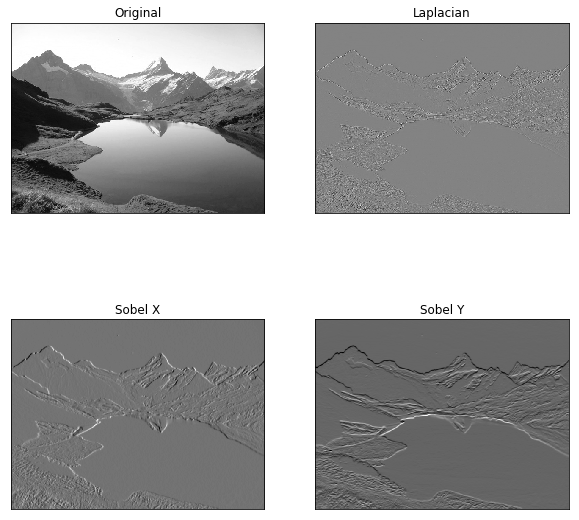

In [110]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = imread('imgs/nature.jpg')
gimg = green(img)

laplacian = cv.Laplacian(gimg,cv.CV_64F)
sobelx = cv.Sobel(gimg,cv.CV_64F,1,0,ksize=5)
sobely = cv.Sobel(gimg,cv.CV_64F,0,1,ksize=5)
plt.subplot(2,2,1),plt.imshow(gimg,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])
fig = plt.gcf()
fig.set_size_inches((10,10))

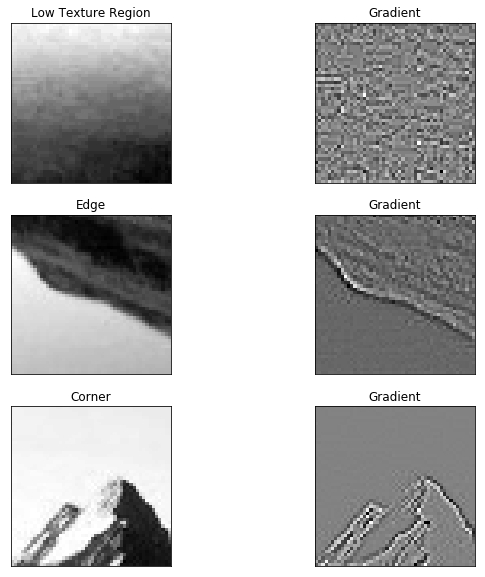

In [111]:
water = gimg[330:380,200:250]
wateredge = gimg[260:310,500:550]
summit = gimg[60:110,320:370]

gwater = cv.Laplacian(water,cv.CV_64F)
gwateredge = cv.Laplacian(wateredge,cv.CV_64F)
gsummit = cv.Laplacian(summit,cv.CV_64F)


plt.subplot(3,2,1),plt.imshow(water,cmap = 'gray')
plt.title('Low Texture Region'), plt.xticks([]), plt.yticks([])
plt.subplot(3,2,2),plt.imshow(gwater,cmap = 'gray')
plt.title('Gradient'), plt.xticks([]), plt.yticks([])
plt.subplot(3,2,3),plt.imshow(wateredge,cmap = 'gray')
plt.title('Edge'), plt.xticks([]), plt.yticks([])
plt.subplot(3,2,4),plt.imshow(gwateredge,cmap = 'gray')
plt.title('Gradient'), plt.xticks([]), plt.yticks([])

plt.subplot(3,2,5),plt.imshow(summit,cmap = 'gray')
plt.title('Corner'), plt.xticks([]), plt.yticks([])
plt.subplot(3,2,6),plt.imshow(gsummit,cmap = 'gray')
plt.title('Gradient'), plt.xticks([]), plt.yticks([])

fig = plt.gcf()
fig.set_size_inches((10,10))

## Harris detector: Algorithm

1. Compute Gaussian derivatives at each pixel
2. Compute second moment matrix M in a Gaussian window around each pixel
3. Compute corner response function R
4. Threshold R
5. Find local maxima of response function (nonmaximum suppression)

## Harris Detector Workflow


<br />
<figure>
  <img src="imgs/harris_workflow1.png" />
  <center><figcaption>Fig.8(a): Original Images</figcaption></center>
</figure>


<br />
<figure>
  <img src="imgs/harris_workflow2.png" />
  <center><figcaption>Fig.8(b): Compute corner response R</figcaption></center>
</figure>

<br />
<figure>
  <img src="imgs/harris_workflow3.png" />
  <center><figcaption>Fig.8(c): Find points with large corner response: R > threshold</figcaption></center>
</figure>

<br />
<figure>
  <img src="imgs/harris_workflow4.png" />
  <center><figcaption>Fig.8(d): Take only the points of local maxima of R</figcaption></center>
</figure>

<br />
<figure>
  <img src="imgs/harris_workflow5.png" />
  <center><figcaption>Fig.8(e): Final results</figcaption></center>
</figure>

In [256]:
def findCorners(filename, window_size, k, thresh):
    """
    Finds and returns list of corners and new image with corners drawn
    :param img: The original image
    :param window_size: The size (side length) of the sliding window
    :param k: Harris corner constant. Usually 0.04 - 0.06
    :param thresh: The threshold above which a corner is counted
    :return:
    """
    img = imread(filename)
    gimg = gray(img)
    #Find x and y derivatives
    dx = cv.Sobel(gimg,cv.CV_64F,1,0,ksize=5)
    dy = cv.Sobel(gimg,cv.CV_64F,0,1,ksize=5)
    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2
    height = int(img.shape[0])
    width = int(img.shape[1])

    cornerList = []
    color_img = img.copy()
    offset = int(window_size/2)

    #Loop through image and find our corners
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            #Calculate sum of squares
            windowIxx = Ixx[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIxy = Ixy[y-offset:y+offset+1, x-offset:x+offset+1]
            windowIyy = Iyy[y-offset:y+offset+1, x-offset:x+offset+1]
            Sxx = windowIxx.sum()
            Sxy = windowIxy.sum()
            Syy = windowIyy.sum()

            #Find determinant and trace, use to get corner response
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            r = det - k*(trace**2)
            
            ## For some reason the values are very high, so devide
            r = r/1000000000000.0
            
            #If corner response is over threshold, color the point and add to corner list
            if r  > thresh:
                cornerList.append([x, y, r])
                color_img.itemset((y, x, 0), 0)
                color_img.itemset((y, x, 1), 0)
                color_img.itemset((y, x, 2), 255)
    imshow(color_img)

OpenCV implementation


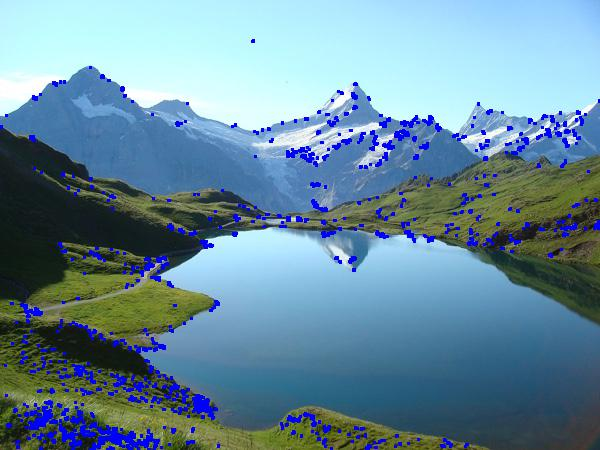

Local implementation


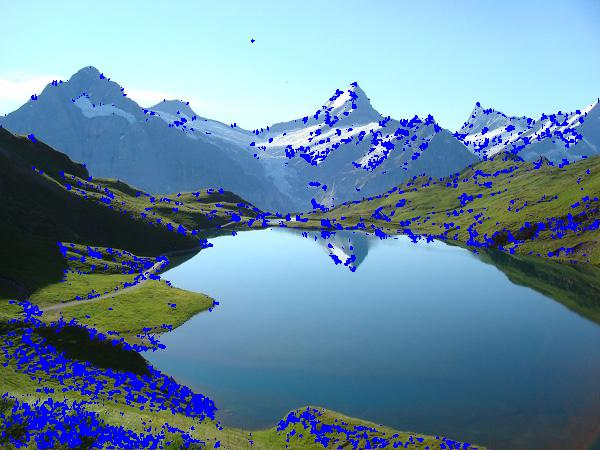

In [258]:
print("OpenCV implementation")
calculate_haris_corner('imgs/nature.jpg')
print("Local implementation")
findCorners("imgs/nature.jpg",2.0,0.04,10.0)

## Other corners:

Shi-Tomasi '94:

"Cornerness" = $min(\lambda_1,\lambda_2)$ Find local maximums cvGoodFeaturesToTrack(..)<br/>
Reportedly better for refion undergoing affine deformations
<br />
<figure>
  <img src="imgs/other_corners.png" />
  <center><figcaption>Fig.9</figcaption></center>
</figure>
<br />
- Brown, M., Szeliski, R., and Winder, S. (2005):
$$\frac{det\,\, M}{tr\,\, M} = \frac{\lambda_0\lambda_1}{\lambda_0+\lambda_1}$$

- There are others....

In [ ]:
## cvGoodFeaturesToTrack

# =====================================
#  4A - L3 Scale invariance
# =====================================

## Harris Detector Properties

Rotation invariance?

<br />
<figure>
  <img src="imgs/rotation_harris.png" />
  <center><figcaption>Fig.9(a): Rotation invariance</figcaption></center>
</figure>


Ellipse rotates but its shape (i.e. eigenvalues) remains the same

Repeatability rate:

$$\frac{\# correspondences}{\# possible\,\, correspondences}$$

<figure>
  <img src="imgs/rotation_harris2.png" />
  <center><figcaption>Fig.9(b): Repeatability rate</figcaption></center>
</figure>



In [259]:
## You are welcome to show the previous theory in code....

## More Haris Detector Properties

- Mostly invariant to additive and multiplicative intensity changes(threshold issue for multiplicative)
    - Only derivatives are used -> invariance to intensity shift I --> I +  b
    - Intensity scale: I --> a*I
    
<br />
<figure>
  <img src="imgs/multi_harris.png" />
  <center><figcaption>Fig.10 (a): Multiplicative intensity</figcaption></center>
</figure>


- Invariant to image scale?
    - <font color="red">Not</font> invariant to image scale!
    
<br />
<figure>
  <img src="imgs/scale_harris.png" />
  <center><figcaption>Fig.10 (b): Harris not invariant to scale</figcaption></center>
</figure>
<br />
<figure>
  <img src="imgs/scale_harris2.png" />
  <center><figcaption>Fig.10 (c): Repeatability measure for scale</figcaption></center>
</figure>

In [260]:
## You are welcome to show the previous theory in code....

## Scale Invariant Detection

- Consider regions (e.g. circles) of different sizes around a point
- Regions of corresponding sizes will look the same in both images

- The problem: how do we choose corresponding circles <font color="green">independently</font> in each image?

<br />
<figure>
  <img src="imgs/scale_inv_harris.png" />
  <center><figcaption>Fig.11: scale invariant</figcaption></center>
</figure>


- Solution:
    - Design a function on the region (circle), which is "scale invariant" - not affected by the size but will be the same for "corresponding regions," even if they are at different sizes/scales

    <font color="blue">Example</font>: Average intensity. For corresponding regions (even of different sizes) it will be the same

## One Method fro Scale Invariant Detection

One method:
- At a point, compute the scale invariant function of different size neighborhoods (different scales).


<br />
<figure>
  <img src="imgs/one_method_s_i.png" />
  <center><figcaption>Fig.12 (a) scalling around a certain point</figcaption></center>
</figure>

- Important: this scale invariant region size is found in each image independently



<br />
<figure>
  <img src="imgs/one_method_s_i2.png" />
  <center><figcaption>Fig.12 (b) example</figcaption></center>
</figure>



In [ ]:
## You are welcome to show the previous theory in code....

## A Food Function for Scale Detection

- A "good" function for scale detection:
    has one stable sharp peak
    
<br />
<figure>
  <img src="imgs/good_s_i_func.png" />
  <center><figcaption>Fig.13 (a): good scale invariant function</figcaption></center>
</figure>

For usual images: a good function would be a one which responds to contrast (sharp local intensity change)

Function is just application of a kernel: <font color="green"> f = Kernel * Image</font>

$$ L = \sigma^2(G_{xx}(x,y,\sigma) + G_{yy}(x,y,\sigma))$$

Laplacian of Gaussian- LoG

$$ DoG = \sigma^2(G_{xx}(x,y,k\sigma) + G_{yy}(x,y,\sigma))$$

Difference of Gaussians

Both kernals are invariant to scale and rotation

<br />
<figure>
  <img src="imgs/good_s_i_func2.png" width=300/>
  <center><figcaption>Fig.13 (b): LoG vs DoG</figcaption></center>
</figure>

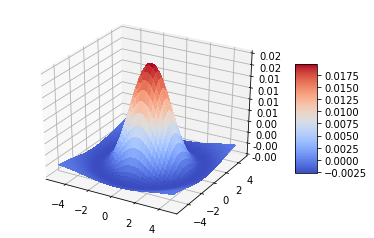

In [284]:
## Show Laplacian of Gaussian

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
#R = np.sqrt(X**2 + Y**2)
#R = X**2 + Y**2
sigma = 2
Z = -1*1/(np.pi*np.power(sigma,4))*(1-(X**2 + Y**2)/(2*np.power(sigma,2)))*np.exp(-(X**2 + Y**2)/(2*np.power(sigma,2)))
Z *= -1

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

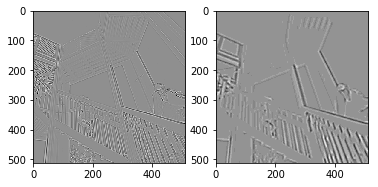

In [262]:
from scipy import ndimage, misc
import matplotlib.pyplot as plt
ascent = misc.ascent()
fig = plt.figure()
plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side
result = ndimage.gaussian_laplace(ascent, sigma=1)
ax1.imshow(result)
result = ndimage.gaussian_laplace(ascent, sigma=3)
ax2.imshow(result)
plt.show()

## Key Point Localization

- General idea: find robust extremum (maximum of minimum) both in space in scale
- Specific suggestion: use DoG pyramid to find maximum values (remember edge detection?) - then eliminate "edges" and pick only corners

### Scale space processed one octave at a time

<br />
<figure>
  <img src="imgs/key_point_localization.png" width=300 />
  <center><figcaption>Fig.14 (a): key point localization</figcaption></center>
</figure>


Each point is compared to its 8 neighbors in the current image and 0 neighbors each in the scale above and below

<br />
<figure>
  <img src="imgs/key_point_localization2.png" width=300 />
  <center><figcaption>Fig.14 (b): key point localization</figcaption></center>
</figure>

## Extrema at different scales

<br />
<figure>
  <img src="imgs/extrema_dif_sc.png" width=300 />
  <center><figcaption>Fig.15(a): Extrema at different scales</figcaption></center>
</figure>
<br />
<figure>
  <img src="imgs/extrema_dif_sc2.png"  width=300/>
  <center><figcaption>Fig.15(b): Extrema at different scales</figcaption></center>
</figure>

### Scale Invariant Detectors

SIFT(LOWE)<br />
Find local maximum of:
- Difference of Gaussians in space and scale

<br />
<figure>
  <img src="imgs/sift.png"  width=300/>
  <center><figcaption>Fig.15(c): Sift</figcaption></center>
</figure>

Harris-Laplacian<br />
Find local maximum of:
    - Harris corner detector in space (image coordinates)
    - Laplacian in scale
    
<br />
<figure>
  <img src="imgs/harris_laplacian.png"  width=300/>
  <center><figcaption>Fig.15(d): harris-laplacian</figcaption></center>
</figure>


<br />
<figure>
  <img src="imgs/harris_vs_sift.png"  width=300/>
  <center><figcaption>Fig.15(e): harris vs sift</figcaption></center>
</figure>

In [ ]:
## Code to show comparision

In [ ]:
<font color="green"></font>

<br />
<figure>
  <img src="imgs/good_s_i_func.png" />
  <center><figcaption>Fig.13: good scale invariant function</figcaption></center>
</figure>